# 데이터 로드

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv('open/train.csv')
df2 = df.copy()
test_df = pd.read_csv('open/test.csv')

print(df.shape)
print(test_df.shape)

(3000, 18)
(3000, 17)


# 전처리

In [5]:
df['mean_working'] = df['mean_working'].fillna(0)


df = df.fillna('Unknown')

d_gender = {
    "F" : 0,
    "M" : 1
}

d_activity = {
    "light" : 0,
    "moderate" : 1,
    "intense" : 2
}

d_smoke_status = {
    "non-smoker" : 0,
    "ex-smoker" : 1,
    "current-smoker" : 2
}

d_edu_level = {
    'high school diploma' : 1,
    'bachelors degree' : 2,
    'graduate degree' : 3,
    'Unknown' : 0
}


d_sleep_pattern = {
    'sleep difficulty' : 0,
    'normal' : 1,
    'oversleeping' : 2
}

In [6]:
df['gender'] = df['gender'].map(d_gender)
df['activity'] = df['activity'].map(d_activity)
df['smoke_status'] = df['smoke_status'].map(d_smoke_status)
df['edu_level'] = df['edu_level'].map(d_edu_level)
df['sleep_pattern'] = df['sleep_pattern'].map(d_sleep_pattern)

mh_dummies    = pd.get_dummies(df['medical_history'], prefix="mh", dtype='int')
fmh_dummies   = pd.get_dummies(df['family_medical_history'], prefix="fmh", dtype='int')
smo_dummies   = pd.get_dummies(df['smoke_status'], prefix="smo", dtype='int')

# 2. 원본 df에 concat
df = pd.concat([df, mh_dummies, fmh_dummies,smo_dummies], axis=1)

# 3. 기존 원본 컬럼 삭제
df = df.drop(["ID",'medical_history', 'family_medical_history','smoke_status'], axis=1)

df.to_csv('train_preprocessed.csv', index=False)

In [7]:

test_df['mean_working'] = test_df['mean_working'].fillna(0)

test_df = test_df.fillna('Unknown')


test_df['gender'] = test_df['gender'].map(d_gender)
test_df['activity'] = test_df['activity'].map(d_activity)
test_df['smoke_status'] = test_df['smoke_status'].map(d_smoke_status)
test_df['edu_level'] = test_df['edu_level'].map(d_edu_level)
test_df['sleep_pattern'] = test_df['sleep_pattern'].map(d_sleep_pattern)

mh_dummies    = pd.get_dummies(test_df['medical_history'], prefix="mh", dtype='int')
fmh_dummies   = pd.get_dummies(test_df['family_medical_history'], prefix="fmh", dtype='int')
smo_dummies   = pd.get_dummies(test_df['smoke_status'], prefix="smo", dtype='int')

# 2. 원본 test_df에 concat
test_df = pd.concat([test_df, mh_dummies, fmh_dummies,smo_dummies], axis=1)

# 3. 기존 원본 컬럼 삭제
test_df = test_df.drop(["ID",'medical_history', 'family_medical_history','smoke_status'], axis=1)

test_df.to_csv('test_preprocessed.csv', index=False)

# 학습

In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.svm import SVR
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

# 전처리 데이터 로드
df = pd.read_csv('train_preprocessed.csv')
test_df = pd.read_csv('test_preprocessed.csv')  
print(df.shape, test_df.shape)

# BMI 피처 추가
df['bmi'] = (df['weight'] / ((df['height'] / 100.0) ** 2)).round(2)
test_df['bmi'] = (test_df['weight'] / ((test_df['height'] / 100.0) ** 2)).round(2)

print(df.shape, test_df.shape)  

X = df.drop(columns=['stress_score']) 
y = df['stress_score']

(3000, 25) (3000, 24)
(3000, 26) (3000, 25)


+ SVR 하이퍼 파라미터 튜닝

In [9]:
# def tune_svr_rbf_mae_cv(X, y, max_evals=60, n_splits=5, random_state=42): 
#     X_arr = X.values if hasattr(X, "values") else np.asarray(X)
#     y_arr = y.values if hasattr(y, "values") else np.asarray(y)

#     def objective(params):
       
#         kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
#         fold_maes = []

#         for tr_idx, val_idx in kf.split(X_arr):
#             X_tr, X_val = X_arr[tr_idx], X_arr[val_idx]
#             y_tr, y_val = y_arr[tr_idx], y_arr[val_idx]

#             # 누수 방지 fold 안 스케일링

#             pipe = make_pipeline(
#                 RobustScaler(),
#                 TransformedTargetRegressor(
#                     regressor=SVR(
#                         kernel="rbf",
#                         C=params["C"],
#                         gamma=params["gamma"],
#                         epsilon = 0.0, 
#                         shrinking=True,
#                         cache_size=500,   
#                         max_iter=-1
#                     ),
#                    transformer=QuantileTransformer(output_distribution="normal",
#                                         n_quantiles=min(1000, len(y_tr)))
#                 )
#             )

#             pipe.fit(X_tr, y_tr)
#             pred = pipe.predict(X_val)
#             fold_maes.append(mean_absolute_error(y_val, pred))

#         mean_mae = float(np.mean(fold_maes))
#         return {"loss": mean_mae, "status": STATUS_OK}

#     # 좁힌 탐색 공간 -> 넓은 범위로 돌렸을 때 찾은 값
#     bestC, bestG = 3.2921101346679285, 0.39164577291716846

#     space_refine = {
#         "C":       hp.loguniform("C",     np.log(max(1e-2, bestC/3)), np.log(bestC*3)),   # ~[1.04, 9.34]
#         "gamma":   hp.loguniform("gamma", np.log(max(1e-4, bestG/3)), np.log(bestG*4)),   # ~[0.167, 1.504]
#     }
#     trials = Trials()
#     best = fmin(
#         fn=objective,
#         space=space_refine,
#         algo=tpe.suggest,
#         max_evals=max_evals,
#         trials=trials,
#         rstate=np.random.default_rng(random_state),
#     )

#     best_params = {
#         "C":       float(best["C"]),
#         "gamma":   float(best["gamma"]),
#         "kernel":  "rbf"
#     }

#     best_mae = float(min(r["loss"] for r in trials.results))

#     return {
#         "best_params": best_params,
#         "best_cv_mae": best_mae,
#         "trials": trials, 
#         "best": best
#     }

# summary = tune_svr_rbf_mae_cv(X,
#                          y, 
#                           max_evals=80,  
#                           n_splits=10) 
# print("CV MAE:", summary["best_cv_mae"])
# print("Best params:", summary["best_params"])

+ 모델 학습

In [10]:
Best_params =  {'C': 3.963530707518144, 'gamma': 1.0631617004546035}   # 위 방식으로 찾아진 최적 하이퍼 파라미터


pipe = make_pipeline(
    RobustScaler(),  # X 스케일
    TransformedTargetRegressor( 
        regressor=SVR(
            **Best_params,
            kernel="rbf",
            epsilon = 0.0),
         transformer=QuantileTransformer(output_distribution="normal",
                                        n_quantiles=min(1000, len(y)))
    )
)

# 학습
pipe.fit(X, y)

# 학습 MAE 확인 
print("train mae:", mean_absolute_error(y, pipe.predict(X)))

train mae: 3.3333333333333363e-06


# 추론

<Axes: >

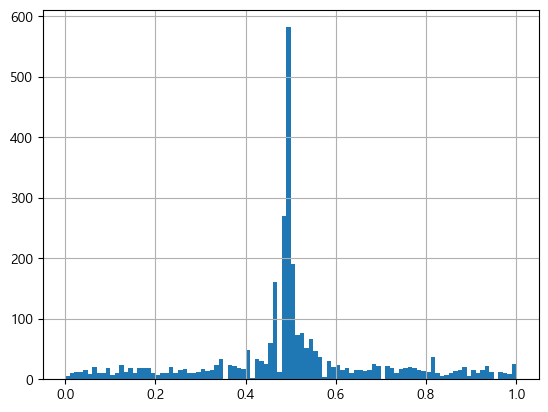

In [11]:
# 테스트 예측 + 제출 저장
submit = pd.read_csv("open/sample_submission.csv")

pred = pipe.predict(test_df)
submit["stress_score"] = pred
submit.to_csv("final_submission.csv", index=False)

# 분포 시각화
submit["stress_score"].hist(bins = 100)